In [ ]:
%load_ext autoreload
%autoreload 2

# Logit on Orders

## Select features

the impact of wait_time and delay_vs_expected on very good/bad reviews

orders training_set I will run 2 multivariate logistic regressions:
- logit_one to predict dim_is_one_star 
- logit_five to predict dim_is_five_star.

 

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [3]:
#selecting the features to use
selected_features = ["wait_time", 
            "delay_vs_expected",
            "number_of_sellers", 
            "distance_seller_customer", 
            "price", 
            "freight_value"]

In [4]:
# First, standardize the data

orders_standardized = orders.copy()

for f in selected_features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
    
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_three_star,dim_is_two_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,0,0,4,1,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,0,0,4,1,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,0,0,5,1,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,0,0,5,1,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,0,0,5,1,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,0,0,5,1,-0.112544,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,0,0,4,1,-0.112544,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,0,0,5,1,-0.112544,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,1,0,2,2,-0.112544,1.075186,2.715522,-0.387558


In [5]:
#VIF Analysis to analyze the potential multicolinearities:
X_standardized = orders_standardized[selected_features]
X_standardized.head()

,wait_time,delay_vs_expected,number_of_sellers,distance_seller_customer,price,freight_value
0,-0.431192,-0.161781,-0.112544,-0.979475,-0.513802,-0.652038
1,0.134174,-0.161781,-0.112544,0.429743,-0.086640,0.000467
2,-0.329907,-0.161781,-0.112544,-0.145495,0.111748,-0.164053
3,0.073540,-0.161781,-0.112544,2.054621,-0.441525,0.206815
4,-1.019535,-0.161781,-0.112544,-0.959115,-0.562388,-0.652038


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.DataFrame()
df["features"] = X_standardized.columns
df["vif_index"] = [vif(X_standardized.values, i) for i in range(X_standardized.shape[1])]
round(df,2)

,features,vif_index
0,wait_time,2.62
1,delay_vs_expected,2.21
2,number_of_sellers,1.02
3,distance_seller_customer,1.41
4,price,1.21
5,freight_value,1.36


The multi-colinearity of the features, using the VIF index

    
VIF index shouldn't be too high. preferable <10 to make sure we can trust the partial regression coefficients and the associated p-values

## Logistic Regressions

Two Logistic Regression models
- logit_one to predict dim_is_one_star
- logit_five to predict dim_is_five_star

In [8]:
selected_features

['wait_time',
 'delay_vs_expected',
 'number_of_sellers',
 'distance_seller_customer',
 'price',
 'freight_value']

In [14]:
logit_one = smf.logit(formula='dim_is_one_star ~ wait_time + delay_vs_expected + number_of_sellers + distance_seller_customer + price + freight_value', data = orders_standardized).fit()
print(logit_one.summary())

Optimization terminated successfully.
         Current function value: 0.276470
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                  0.1357
Time:                        12:43:40   Log-Likelihood:                -26506.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4472      0.013   -191.764      0.000      -2.472

In [16]:
# logit 5 star
logit_five = smf.logit(formula='dim_is_five_star ~ wait_time + delay_vs_expected + number_of_sellers + distance_seller_customer + price + freight_value', data = orders_standardized).fit()
print(logit_five.summary())

Optimization terminated successfully.
         Current function value: 0.638281
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                 0.05591
Time:                        12:45:49   Log-Likelihood:                -61193.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3383      0.007     47.337      0.000       0.324

all things being equal:
- delay_vs_expected influences five_star ratings even more than one_star ratings
- wait_time influences one_star ratings more more than five_star

however, we compare coefficients from 2 different models.. they might not have the same populations ( people who give 1 stars and people that give 5 stars) 


## Logistic vs. Linear ?

In [19]:
linear_model = smf.ols(formula='dim_is_five_star ~ wait_time + delay_vs_expected + number_of_sellers + distance_seller_customer + price + freight_value', data = orders_standardized).fit()

In [20]:
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:       dim_is_five_star   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1092.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:56:45   Log-Likelihood:                -64759.
No. Observations:               95872   AIC:                         1.295e+05
Df Residuals:                   95865   BIC:                         1.296e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [21]:
print(logit_five.summary())

                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jun 2022   Pseudo R-squ.:                 0.05591
Time:                        12:56:59   Log-Likelihood:                -61193.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3383      0.007     47.337      0.000       0.324       0.352
wait_time                   -0.5140      0.012    -44.101      0.000      -0.537      -0.

<AxesSubplot:title={'center':'Logit'}>

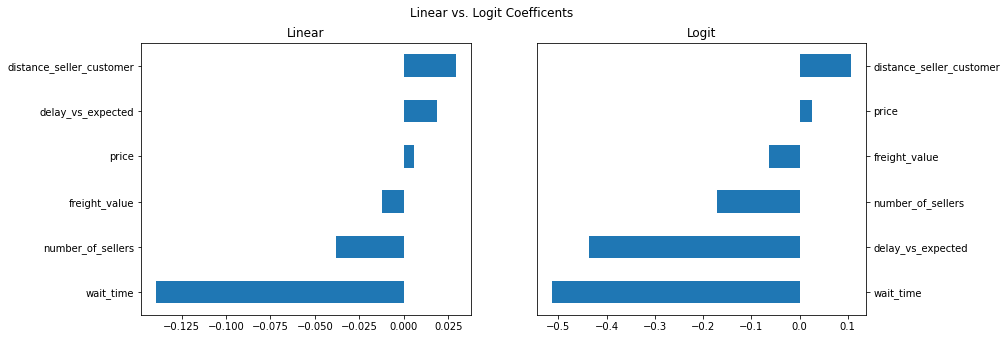

In [24]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficents')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)


ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)